In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
lastYear = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(lastYear)

('2017-08-23',)


2016-08-23 00:00:00


Text(0, 0.5, 'Precipitation')

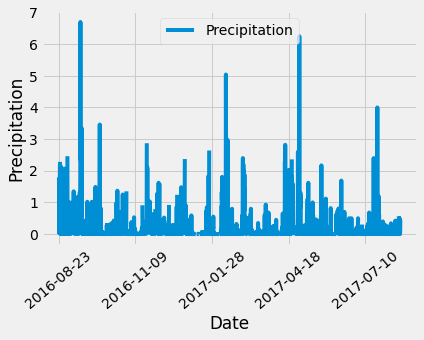

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latestDate = dt.datetime.strptime(lastYear[0], '%Y-%m-%d')
queryDate = dt.date(latestDate.year -1, latestDate.month, latestDate.day)
queryDate
# Calculate the date one year from the last date in data set.
latestDate = dt.datetime.strptime(lastYear[0], '%Y-%m-%d')
startDate = latestDate - dt.timedelta(365)
print(startDate)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,measurement.prcp]
queryResult = session.query(*sel).filter(measurement.date >= queryDate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(queryResult, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation = precipitation.sort_values(['Date'], ascending=True)
precipitation = precipitation.set_index('Date')
precipitation

# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot(rot=40)
plt.xlabel('Date')
plt.ylabel('Precipitation')



In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [measurement.station,func.count(measurement.id)]
stationsActive = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
stationsActive

most_active_station = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
most_active_station

('USC00519281', 2772)

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_data = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_data

(54.0, 85.0, 71.66378066378067)

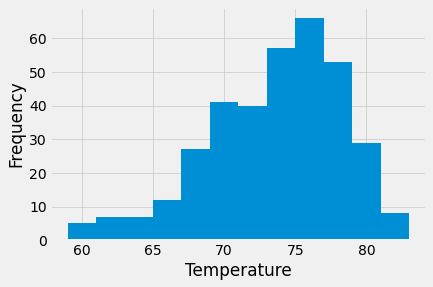

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryResult = session.query(measurement.tobs).\
    filter(measurement.station == stationsActive[0][0]).\
    filter(measurement.date >= queryDate).all()
temperatures = list(np.ravel(queryResult))

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation]
queryResult = session.query(*sel).all()
stationData = pd.DataFrame(queryResult, columns = [ 'Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

stationName = stationData.loc[stationData['Station'] == stationsActive[0][0], 'Name'].tolist()[0]

plt.hist(temperatures, bins=12, rwidth=1.0)
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close session

In [ ]:
# Close Session
session.close()